In [1]:
import json
#import jsonlines
import pickle
import pandas as pd
import numpy as np
from scipy.stats import entropy, chisquare, kstest, ks_2samp
from scipy.spatial import distance
from scipy.stats import epps_singleton_2samp, chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
# from sklearn.model_selection import LeaveOneOut
# from sklearn.cross_validation import LeaveOneOut
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
%matplotlib inline


def get_top_k_count(real_topk, top1 = 10, top2 = 100, top3 = 1000):
    # takes in the json part for real_topk and returns the counts of top1,2,3,4
    # top4 is just whatever is past the last number, for example >1000
    # returns list in order of top1 to top4 bins
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    for item in real_topk:
        if(item[0] < top1):
            t1 = t1 + 1
        elif(item[0] < top2):
            t2 = t2 + 1
        elif(item[0] < top3):
            t3 = t3 + 1
        else:
            t4 = t4 + 1
    return [t1, t2, t3, t4]


def get_top_k_count_from_file(json_file, top1 = 10, top2 = 100, top3 = 1000):
    # takes in the json file and returns the counts of top1,2,3,4
    # top4 is just whatever is past the last number, for example >1000
    # returns list in order of top1 to top4 bins
    return get_top_k_count(json_file["result"]["real_topk"], top1, top2, top3)


def get_frac_p(real_topk, pred_topk):
    # takes in real_topk and pred_topk and returns list of
    # frac(p)
    res = []
    for i in range(len(real_topk)):
        res.append(real_topk[i][1] / pred_topk[i][0][1])
    return res


def fracp_bin_counter(fracp):
    # takes in the list of all frac(p) and returns list of buckets from 0-1
    # counting by 0.1
    b0 = 0
    b1 = 0
    b2 = 0
    b3 = 0
    b4 = 0
    b5 = 0
    b6 = 0
    b7 = 0
    b8 = 0
    b9 = 0

    for val in fracp:
        if(val <= 0.1):
            b0 = b0 + 1
        elif(val <= 0.2):
            b1 = b1 + 1
        elif(val <= 0.3):
            b2 = b2 + 1
        elif (val <= 0.4):
            b3 = b3 + 1
        elif (val <= 0.5):
            b4 = b4 + 1
        elif (val <= 0.6):
            b5 = b5 + 1
        elif (val <= 0.7):
            b6 = b6 + 1
        elif (val <= 0.8):
            b7 = b7 + 1
        elif (val <= 0.9):
            b8 = b8 + 1
        else:
            b9 = b9 + 1
    # print([b0, b1, b2, b3, b4, b5, b6, b7, b8, b9])
    return [b0, b1, b2, b3, b4, b5, b6, b7, b8, b9]


def fracp_bin_counter_from_file(json_file):
    # takes json file (json structure) and returns bins count
    rtk = json_file["result"]["real_topk"]
    ptk = json_file["result"]["pred_topk"]
    return fracp_bin_counter(get_frac_p(rtk, ptk))


def zero_to_small_num(lst):
    # takes a list and replaces all 0 with a small number
    for i in range(len(lst)):
        if lst[i] == 0:
            lst[i] = 0.0000000000000000000001
    return lst


def get_kld(fp_bin1, fp_bin2):
    # given two list of bin counts (10 long by default)
    # returns KLD value
    return entropy(fp_bin1, fp_bin2)


def get_kld_from_json_file(file1, file2):
    # given two json objects
    # returns KLD value
    # this skips a lot of steps to make it easier
    realtk_1 = file1["result"]["real_topk"]
    predtk_1 = file1["result"]["pred_topk"]
    realtk_2 = file2["result"]["real_topk"]
    predtk_2 = file2["result"]["pred_topk"]

    bins1 = fracp_bin_counter(get_frac_p(realtk_1, predtk_1))
    bins2 = fracp_bin_counter(get_frac_p(realtk_2, predtk_2))
    print(str(bins1) + "                   " + str(bins2))
    # bins1 = zero_to_small_num(bins1)
    # bins2 = zero_to_small_num(bins2)
    print(str(bins1) + "                   " + str(bins2))
    return get_kld(bins1, bins2)


def get_jsd(fp_bin1, fp_bin2):
    # given two list of bin counts, (10 long by default)
    # returns JSD value
    return distance.jensenshannon(fp_bin1, fp_bin2)


def compare_json_files_kld(filename1, filename2):
    # given two file names, get json from it, then use kld
    # returns list of all kld values
    lst = []
    with open(filename1) as f1:
        d1 = json.load(f1)
    with open(filename2) as f2:
        d2 = json.load(f2)
    print(str(len(d1))+"       F2:"+str(len(d2)))

    for d1x in d1:
        for d2x in d2:
            # print("D1: " + str(d1x) + "           D2: " + str(d2x))
            lst.append(get_kld_from_json_file(d1x, d2x))
            print(lst[-1])
    return lst


def list_of_fracp_from_file(filename):
    # given a file name, get json from it, then return list
    # returns list of 10 frac p bins
    lst = []
    with open(filename) as f1:
        d1 = json.load(f1)
#     print(d1)
#     for d1x in d1:
#         lst.append()
    return fracp_bin_counter_from_file(d1)


def list_of_fracp_from_jsonl_file(filename):
    # given two file names of json lines, get json from it, then return list
    # returns list of list of 10 frac p bins
    lst = []
    with jsonlines.open(filename) as reader:
        for obj in reader:
            lst.append(fracp_bin_counter_from_file(obj))
    return lst


def list_of_norm_fracp_from_file(filename):
    # given two file names, get json from it, then return list
    # returns list of list of 10 frac p bins that are normalized
    lst = []
    with open(filename) as f1:
        d1 = json.load(f1)

    for d1x in d1:
        bins = fracp_bin_counter_from_file(d1x)
        tot = sum(bins)
        for i in range(10):
            bins[i] = bins[i] / tot
        print(sum(bins))
        lst.append(bins)
    return lst

### List of pickles to use
- "fracp.GPT2-human-25000-pd-normalized.pickle"
- "fracp.GPT2-machine-25000-pd-normalized.pickle"
- "fracp.GROVER-human-15000-pd-normalized.pickle"
- "fracp.GROVER-machine-10000-pd-normalized.pickle"
- "fracp.GPT3-machine-485-pd-normalized.pickle"

Please note that each pickle may not contain the exact number specified in the name.

### Plotting Machine and Human results from GPT-2

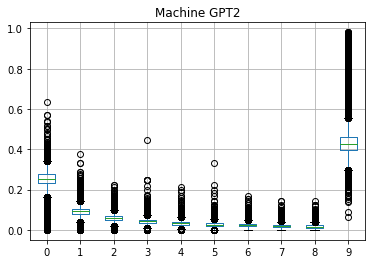

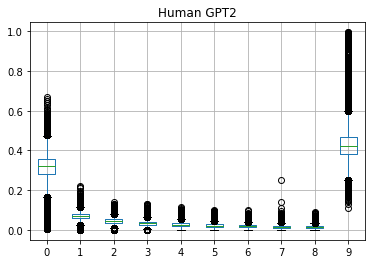

In [2]:
observed = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
expected = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
# print(observed)
# print(expected)
plt.title("Machine GPT2")
observed.boxplot()
plt.subplots(0,2)
plt.title("Human GPT2")
expected.boxplot()

Power_divergenceResult(statistic=0.031895314243821415, pvalue=0.999999999845967)


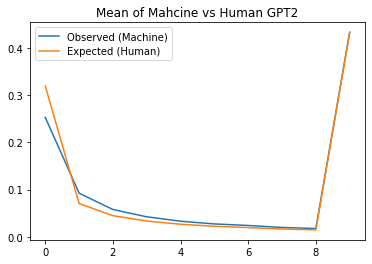

In [3]:
observed_means = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle").mean(axis=0)
expected_means = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").mean(axis=0)

# if not using mean, need to replace expected 0 with small value to avoid div by 0
# expected = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").replace(0, 0.00000000000000000000000000000001)

chi_res = chisquare(observed_means, expected_means, 0, 0)
print(chi_res)
plt.title("Mean of Mahcine vs Human GPT2")
observed_means.plot(label='Observed (Machine)')
expected_means.plot(label='Expected (Human)')
plt.legend()


Power_divergenceResult(statistic=0.41009215963000345, pvalue=0.9999870632009394)


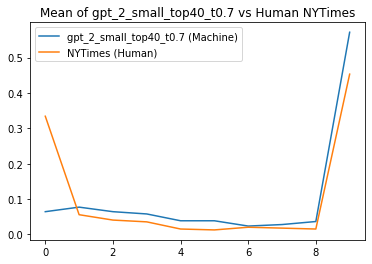

In [7]:
# GLTR example
machine = list_of_fracp_from_file('gpt_2_small_top40_t0.7.json')
human = list_of_fracp_from_file('NYTimes.json')
hum = pd.DataFrame(human).T
mac = pd.DataFrame(machine).T
hum = hum.div(hum.sum(axis=1), axis=0).mean(axis=0)
mac = mac.div(mac.sum(axis=1), axis=0).mean(axis=0)

# if not using mean, need to replace expected 0 with small value to avoid div by 0
# expected = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").replace(0, 0.00000000000000000000000000000001)

chi_res = chisquare(mac, hum, 0, 0)
print(chi_res)
plt.title("Mean of gpt_2_small_top40_t0.7 vs Human NYTimes")
mac.plot(label='gpt_2_small_top40_t0.7 (Machine)')
hum.plot(label='NYTimes (Human)')
plt.legend()

###                                Chi Squared Probabilities Table
| df || 0.995 |  0.99 | 0.975 |  0.95 |  0.90 |   0.10 |   0.05 |  0.025 |   0.01 |  0.005 |
|---:||------:|------:|------:|------:|------:|-------:|-------:|-------:|-------:|-------:|
|  1 ||   --- |   --- | 0.001 | 0.004 | 0.016 |  2.706 |  3.841 |  5.024 |  6.635 |  7.879 |
|  2 || 0.010 | 0.020 | 0.051 | 0.103 | 0.211 |  4.605 |  5.991 |  7.378 |  9.210 | 10.597 |
|  3 || 0.072 | 0.115 | 0.216 | 0.352 | 0.584 |  6.251 |  7.815 |  9.348 | 11.345 | 12.838 |
|  4 || 0.207 | 0.297 | 0.484 | 0.711 | 1.064 |  7.779 |  9.488 | 11.143 | 13.277 | 14.860 |
|  5 || 0.412 | 0.554 | 0.831 | 1.145 | 1.610 |  9.236 | 11.070 | 12.833 | 15.086 | 16.750 |
|  6 || 0.676 | 0.872 | 1.237 | 1.635 | 2.204 | 10.645 | 12.592 | 14.449 | 16.812 | 18.548 |
|  7 || 0.989 | 1.239 | 1.690 | 2.167 | 2.833 | 12.017 | 14.067 | 16.013 | 18.475 | 20.278 |
|  8 || 1.344 | 1.646 | 2.180 | 2.733 | 3.490 | 13.362 | 15.507 | 17.535 | 20.090 | 21.955 |
|  9 || 1.735 | 2.088 | 2.700 | 3.325 | 4.168 | 14.684 | 16.919 | 19.023 | 21.666 | 23.589 |

###### Source: https://people.richland.edu/james/lecture/m170/tbl-chi.html

In [4]:
# example https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html
X = np.array([[1, 2], [3, 4]])
y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo)
print(loo.get_n_splits(X))
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

LeaveOneOut()
2
TRAIN: [1] TEST: [0]
[[3 4]] [[1 2]] [2] [1]
TRAIN: [0] TEST: [1]
[[1 2]] [[3 4]] [1] [2]


In [5]:
# o_np = observed.to_numpy().tolist()
# e_np = expected.to_numpy().tolist()
# # print(len(o_np))
# gpt_loo = LeaveOneOut()
# n = gpt_loo.get_n_splits(e_np)
# print(n)
# for train_index, test_index in loo.split(e_np):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = e_np[train_index], e_np[test_index]
#     y_train, y_test = o_np[train_index], o_np[test_index]
#     print(X_train, X_test, y_train, y_test)

In [3]:
def is_chisqr_independent(observed, expected, ddof = 0, axis = 0):
    chi_res = chisquare(observed, expected, ddof, axis)
    stat = chi_res[0]
    pval = chi_res[1]
    return chi_res

def average_prediction(obsa, expa):
    adf = pd.DataFrame(expa).mean(axis=0).append(pd.DataFrame(obsa).mean(axis=0))
    ret = adf.mean(axis=0)
    return ret


'''Calculates the cross validation chi squared values. If the dataset
is large, uses 10-fold cross validation. Otherwise, uses leave-one-out cross
validation. algorithm is a function that takes in X and y and returns a model (not used for now).
'''
def get_cross_validation_error_meanx(algorithm, X, y):
    print(X)
    print(type(X))
    print("This is X")
    print("============")
    stat = []
    pv = []
    if len(y) > 10000:
        print('Data contains more than 10000 rows. Using 10-fold cross validation...')
        splitter = KFold(n_splits=10, shuffle=True, random_state=4294967295) #2**32 - 1
        
    else:
        print('Using leave-one-out cross validation...')
        splitter = LeaveOneOut()
    
    for train_indices, test_indices in splitter.split(y):
        
        train_y = y[train_indices]

        test_y = y[test_indices]

        mse = is_chisqr_independent(test_y.mean(axis=0), X.mean(axis=0))
        stat.append(mse[0])
        pv.append(mse[1])
    return [stat, pv]
#     return sqrt(sum(errors) / len(errors))

def get_cross_validation_error(algorithm, X, y):

    stat = []
    pv = []
    if len(y) > 10000:
        print('Data contains more than 10000 rows. Using 10-fold cross validation...')
        splitter = KFold(n_splits=10, shuffle=True, random_state=4294967295) #2**32 - 1
        
    else:
        print('Using leave-one-out cross validation...')
        splitter = LeaveOneOut()
    
    for train_indices, test_indices in splitter.split(y):

        train_X, train_y = X[train_indices], y[train_indices]

        test_y = y[test_indices]

        model = train_X.mean(axis=0)

        mse = is_chisqr_independent(test_y.mean(axis=0), model)
        stat.append(mse[0])
        pv.append(mse[1])

    return [stat, pv]


def tempname(observed, expected):
    pass

In [4]:
obs = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
expected_means = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
# print(len(obs))
# print(type(expected_means))
#print(is_chisqr_independent(obs.mean(axis=0), expected_means))
# err = get_cross_validation_error(average_prediction, expected_means.to_numpy(), obs.to_numpy())
######err = get_cross_validation_error_meanx(average_prediction, expected_means.to_numpy(), obs.to_numpy())
err = get_cross_validation_error(average_prediction, expected_means.to_numpy(), obs.to_numpy())
print(err)

Data contains more than 10000 rows. Using 10-fold cross validation...
[[0.03224284518190431, 0.03158551807266718, 0.03266195757723006, 0.0319100917829866, 0.031273161303092135, 0.03099044142004586, 0.031979460998488925, 0.03201755822945258, 0.03225412374359099, 0.032316403868990984], [0.9999999998382921, 0.9999999998525673, 0.9999999998286451, 0.9999999998456465, 0.9999999998589977, 0.9999999998646282, 0.9999999998441352, 0.9999999998433003, 0.9999999998380381, 0.9999999998366302]]


In [61]:
machine = list_of_fracp_from_file('gpt_2_small_top40_t0.7.json')
human = list_of_fracp_from_file('NYTimes.json')
hum = pd.DataFrame(human).T
mac = pd.DataFrame(machine).T
print("human: NYTimes article")
print((hum))
print("\nmachine: GPT-2 small top_k 40 temp .7")
print(mac)
hum = hum.div(hum.sum(axis=1), axis=0)
mac = mac.div(mac.sum(axis=1), axis=0)
print("\nchi squared:")

chi = is_chisqr_independent(mac, hum, 0, 1)
print(chi)

print("\nchi squared:")

chi = is_chisqr_independent(hum, hum, 0, 1)
print(chi)

human: NYTimes article
     0   1   2   3  4  5  6  7  8    9
0  132  22  16  14  6  5  8  7  6  179

machine: GPT-2 small top_k 40 temp .7
    0   1   2   3   4   5   6   7   8    9
0  30  36  30  27  18  18  11  13  17  267

chi squared:
Power_divergenceResult(statistic=array([0.41009216]), pvalue=array([0.99998706]))

chi squared:
Power_divergenceResult(statistic=array([0.]), pvalue=array([1.]))


In [15]:
print(sum(obs.sum(axis=1)))


24999.0


### KS 2 Sample

In [2]:
obs = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
exp = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
obs_mean = obs.mean(axis=0)
exp_mean = exp.mean(axis=0)
print("Observed means: \n" + str(obs_mean) + "\n\n")
print("Expected means: \n" + str(exp_mean) + "\n")

ks2samp = ks_2samp(obs_mean, exp_mean)
print(ks2samp)
print("\n\n")

# GLTR example
machine = list_of_fracp_from_file('gpt_2_small_top40_t0.7.json')
human = list_of_fracp_from_file('NYTimes.json')
hum = pd.DataFrame(human).T
mac = pd.DataFrame(machine).T
hum = hum.div(hum.sum(axis=1), axis=0).mean(axis=0)
mac = mac.div(mac.sum(axis=1), axis=0).mean(axis=0)
print("human: NYTimes article")
print((hum))
print("\nmachine: GPT-2 small top_k 40 temp .7")
print(mac)

ks2samp_gltr = ks_2samp(mac, hum)
print(ks2samp_gltr)

Observed means: 
0    0.252817
1    0.092357
2    0.057768
3    0.042338
4    0.032955
5    0.027230
6    0.023949
7    0.019768
8    0.017406
9    0.433411
dtype: float64


Expected means: 
0    0.319416
1    0.070366
2    0.044730
3    0.033380
4    0.026586
5    0.022175
6    0.019452
7    0.016502
8    0.014535
9    0.432857
dtype: float64

Ks_2sampResult(statistic=0.2, pvalue=0.9944575548290717)



human: NYTimes article
0    0.334177
1    0.055696
2    0.040506
3    0.035443
4    0.015190
5    0.012658
6    0.020253
7    0.017722
8    0.015190
9    0.453165
dtype: float64

machine: GPT-2 small top_k 40 temp .7
0    0.064240
1    0.077088
2    0.064240
3    0.057816
4    0.038544
5    0.038544
6    0.023555
7    0.027837
8    0.036403
9    0.571734
dtype: float64
Ks_2sampResult(statistic=0.5, pvalue=0.16782134274394334)


In [49]:
obs = pd.DataFrame([.04, .03, .02, .01, .01, .01, .01, .01, .01, .85]).T
exp = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
obs_mean = obs.mean(axis=0)
exp_mean = exp.mean(axis=0)
print("Observed means: \n" + str(obs_mean) + "\n\n")
print("Expected means: \n" + str(exp_mean) + "\n\n")

ks2samp = ks_2samp(obs_mean, exp_mean)
print(ks2samp)

Observed means: 
0    0.04
1    0.03
2    0.02
3    0.01
4    0.01
5    0.01
6    0.01
7    0.01
8    0.01
9    0.85
dtype: float64


Expected means: 
0    0.319416
1    0.070366
2    0.044730
3    0.033380
4    0.026586
5    0.022175
6    0.019452
7    0.016502
8    0.014535
9    0.432857
dtype: float64


Ks_2sampResult(statistic=0.6, pvalue=0.05244755244755244)


### EPPS

In [5]:
obs = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
exp = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
obs_mean = obs.mean(axis=0)
exp_mean = exp.mean(axis=0)
print("Observed means: \n" + str(obs_mean) + "\n\n")
print("Expected means: \n" + str(exp_mean) + "\n")

epps = epps_singleton_2samp(obs_mean, exp_mean)
print(epps)
print("\n\n")

# GLTR example
machine = list_of_fracp_from_file('gpt_2_small_top40_t0.7.json')
human = list_of_fracp_from_file('NYTimes.json')
hum = pd.DataFrame(human).T
mac = pd.DataFrame(machine).T
hum = hum.div(hum.sum(axis=1), axis=0).mean(axis=0)
mac = mac.div(mac.sum(axis=1), axis=0).mean(axis=0)
print("human: NYTimes article")
print((hum))
print("\nmachine: GPT-2 small top_k 40 temp .7")
print(mac)

epps_gltr = epps_singleton_2samp(mac, hum, (.4,.8))
print(epps_gltr)

Observed means: 
0    0.252817
1    0.092357
2    0.057768
3    0.042338
4    0.032955
5    0.027230
6    0.023949
7    0.019768
8    0.017406
9    0.433411
dtype: float64


Expected means: 
0    0.319416
1    0.070366
2    0.044730
3    0.033380
4    0.026586
5    0.022175
6    0.019452
7    0.016502
8    0.014535
9    0.432857
dtype: float64

Epps_Singleton_2sampResult(statistic=1.8252281788518971, pvalue=0.7678636122011705)



human: NYTimes article
0    0.334177
1    0.055696
2    0.040506
3    0.035443
4    0.015190
5    0.012658
6    0.020253
7    0.017722
8    0.015190
9    0.453165
dtype: float64

machine: GPT-2 small top_k 40 temp .7
0    0.064240
1    0.077088
2    0.064240
3    0.057816
4    0.038544
5    0.038544
6    0.023555
7    0.027837
8    0.036403
9    0.571734
dtype: float64
Epps_Singleton_2sampResult(statistic=8.253767800872446, pvalue=0.08271239139991979)


### Chi2_contingency (probably wrong)

In [92]:
obs = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
exp = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
obs_mean = obs.mean(axis=0)
exp_mean = exp.mean(axis=0)
print("Observed means: \n" + str(obs_mean) + "\n\n")
print("Expected means: \n" + str(exp_mean) + "\n")

contable = obs_mean.to_frame().T.append(exp_mean.to_frame().T, ignore_index=True)
print(contable)
print("\n\n")


chi2 = chi2_contingency(contable)
print(chi2)
print("\n\n")

# GLTR example
machine = list_of_fracp_from_file('gpt_2_small_top40_t0.7.json')
human = list_of_fracp_from_file('NYTimes.json')
hum = pd.DataFrame(human).T
mac = pd.DataFrame(machine).T
hum = hum.div(hum.sum(axis=1), axis=0).mean(axis=0)
mac = mac.div(mac.sum(axis=1), axis=0).mean(axis=0)
print("human: NYTimes article")
print((hum))
print("\nmachine: GPT-2 small top_k 40 temp .7")
print(mac)

contable2 = mac.to_frame().T.append(hum.to_frame().T, ignore_index=True)
print(contable2)
print("\n\n")

chi2_gltr = chi2_contingency(contable2)
print(chi2_gltr)

Observed means: 
0    0.252817
1    0.092357
2    0.057768
3    0.042338
4    0.032955
5    0.027230
6    0.023949
7    0.019768
8    0.017406
9    0.433411
dtype: float64


Expected means: 
0    0.319416
1    0.070366
2    0.044730
3    0.033380
4    0.026586
5    0.022175
6    0.019452
7    0.016502
8    0.014535
9    0.432857
dtype: float64

          0         1         2         3         4         5         6  \
0  0.252817  0.092357  0.057768  0.042338  0.032955  0.027230  0.023949   
1  0.319416  0.070366  0.044730  0.033380  0.026586  0.022175  0.019452   

          7         8         9  
0  0.019768  0.017406  0.433411  
1  0.016502  0.014535  0.432857  



(0.015658382760002428, 0.9999999999936892, 9, array([[0.28611677, 0.08136163, 0.0512491 , 0.03785868, 0.02977017,
        0.02470281, 0.02170094, 0.01813483, 0.01597072, 0.43313435],
       [0.28611677, 0.08136163, 0.0512491 , 0.03785868, 0.02977017,
        0.02470281, 0.02170094, 0.01813483, 0.01597072, 0.43313435]]))


### Chi2_contingency

In [3]:
contab = [[30, 36, 30, 27, 18, 18, 11, 13, 17, 267], [132, 22, 16, 14, 6, 5, 8, 7, 6, 179]]
chi2_maunal = chi2_contingency(contab)
print(chi2_maunal)
# contab = [[30, 36, 30, 27, 18, 18, 11, 13, 17, 267], [30, 36, 30, 27, 18, 18, 11, 13, 17, 267]]
# chi2_maunal = chi2_contingency(contab)
# print(chi2_maunal)

(108.97633673115413, 2.37560454249525e-19, 9, array([[ 87.76566125,  31.42227378,  24.92111369,  22.21229698,
         13.00232019,  12.46055684,  10.29350348,  10.83526682,
         12.46055684, 241.62645012],
       [ 74.23433875,  26.57772622,  21.07888631,  18.78770302,
         10.99767981,  10.53944316,   8.70649652,   9.16473318,
         10.53944316, 204.37354988]]))


### KLD

In [3]:
print(get_kld(hum, mac))
print(get_kld(mac, hum)) # p is observed and q is model
print(get_kld(exp_mean, obs_mean))
print(get_kld(obs_mean, exp_mean)) # p is observed and q is model

0.33904664098400505
0.23667375171265698
0.015713180294480437
0.015753999123290303


In [10]:
obs_grover = pd.read_pickle("fracp.GROVER-machine-10000-pd-normalized.pickle")
exp_grover = pd.read_pickle("fracp.GROVER-human-15000-pd-normalized.pickle")
obs_grover_mean = obs_grover.mean(axis=0)
exp_grover_mean = exp_grover.mean(axis=0)

print(get_kld(obs_grover_mean, exp_grover_mean))
print(get_kld(obs_mean, exp_grover_mean))


0.001353816033081998
0.017810191308788637
